In [1]:
# 1. Imports
# =====================================================
import numpy as np
import pandas as pd
import joblib

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost.callback import EarlyStopping
from sklearn.metrics import classification_report, average_precision_score, roc_auc_score


In [2]:
# 2. Load Dataset
# =====================================================
df = pd.read_csv("data/raw/transactions.csv")
target_col = "isFraud"  # 👈 adjust if different
X = df.drop(columns=[target_col])
y = df[target_col]

print("Dataset shape:", df.shape)
print("Target distribution:\n", y.value_counts(normalize=True))

Dataset shape: (6362620, 11)
Target distribution:
 isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64


In [3]:
# 3. Train/Validation/Test Split
# =====================================================
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)

Train shape: (3817572, 10)
Validation shape: (1272524, 10)
Test shape: (1272524, 10)


In [4]:
# 4. Preprocessing
# =====================================================
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])
categorical_transformer = Pipeline(steps=[("encoder", OneHotEncoder(handle_unknown="ignore"))])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

In [5]:
# 5. Models & Hyperparameters (reduced for speed)
# =====================================================
models = {
    "log_reg": LogisticRegression(max_iter=100, random_state=42),
    "rf": RandomForestClassifier(random_state=42),
    "xgb": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
}

param_grid = {
    "log_reg": {
        "classifier__C": [0.1, 1],
        "classifier__penalty": ["l2"]
    },
    "rf": {
        "classifier__n_estimators": [50, 100],
        "classifier__max_depth": [5, 10]
    },
    "xgb": {
       
    }
}

In [6]:
# 6. Hyperparameter Tuning on Subset
# =====================================================
# Subset for faster tuning
X_tune, _, y_tune, _ = train_test_split(
    X_train, y_train, test_size=0.7, stratify=y_train, random_state=42
)

X_tune_sub, X_es, y_tune_sub, y_es = train_test_split(
    X_tune, y_tune, test_size=0.2, stratify=y_tune, random_state=42
)

best_params_all = {}

for name, model in models.items():
    print(f"\n🔹 Tuning {name} on subset...")

    # Build pipeline with the current model
    pipe = ImbPipeline([
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("classifier", model),
    ])

    search = RandomizedSearchCV(
        pipe,
        param_distributions=param_grid[name],
        n_iter=2,   # very small for speed
        scoring="average_precision",
        cv=2,       # fewer folds
        verbose=1,
        random_state=42,
        n_jobs=-1
    )

    # ✅ Do NOT pass eval_set here
    search.fit(X_tune_sub, y_tune_sub)

    print(f"✅ Best {name} params: {search.best_params_}")
    print(f"✅ Best PR-AUC (CV): {search.best_score_:.4f}")

    best_params_all[name] = search.best_params_



🔹 Tuning log_reg on subset...
Fitting 2 folds for each of 2 candidates, totalling 4 fits
✅ Best log_reg params: {'classifier__penalty': 'l2', 'classifier__C': 0.1}
✅ Best PR-AUC (CV): 0.5731

🔹 Tuning rf on subset...
Fitting 2 folds for each of 2 candidates, totalling 4 fits
✅ Best rf params: {'classifier__n_estimators': 100, 'classifier__max_depth': 5}
✅ Best PR-AUC (CV): 0.2415

🔹 Tuning xgb on subset...
Fitting 2 folds for each of 1 candidates, totalling 2 fits


c:\Users\user\anaconda3\envs\RetouchIT-ML-AI-Technical-Assessment\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=2. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\user\anaconda3\envs\RetouchIT-ML-AI-Technical-Assessment\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:03:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Best xgb params: {}
✅ Best PR-AUC (CV): 0.9206


In [7]:
# 7. Retrain on FULL Training Data with Best Params
# =====================================================
final_models = {}
for name, model in models.items():
    print(f"\n🚀 Retraining {name} on FULL data...")

    best_params = {
        k.replace("classifier__", ""): v
        for k, v in best_params_all[name].items()
    }
    model.set_params(**best_params)

    pipe = ImbPipeline([
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("classifier", model),
    ])

    pipe.fit(X_train, y_train)
    final_models[name] = pipe

    # Validation eval
    y_val_pred = pipe.predict_proba(X_val)[:, 1]
    print(f"Val PR-AUC: {average_precision_score(y_val, y_val_pred):.4f}")
    print(f"Val ROC-AUC: {roc_auc_score(y_val, y_val_pred):.4f}")


🚀 Retraining log_reg on FULL data...
Val PR-AUC: 0.5945
Val ROC-AUC: 0.9889

🚀 Retraining rf on FULL data...
Val PR-AUC: 0.0021
Val ROC-AUC: 0.6695

🚀 Retraining xgb on FULL data...


c:\Users\user\anaconda3\envs\RetouchIT-ML-AI-Technical-Assessment\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:16:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Val PR-AUC: 0.9522
Val ROC-AUC: 0.9990


In [8]:
pip install joblib

Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


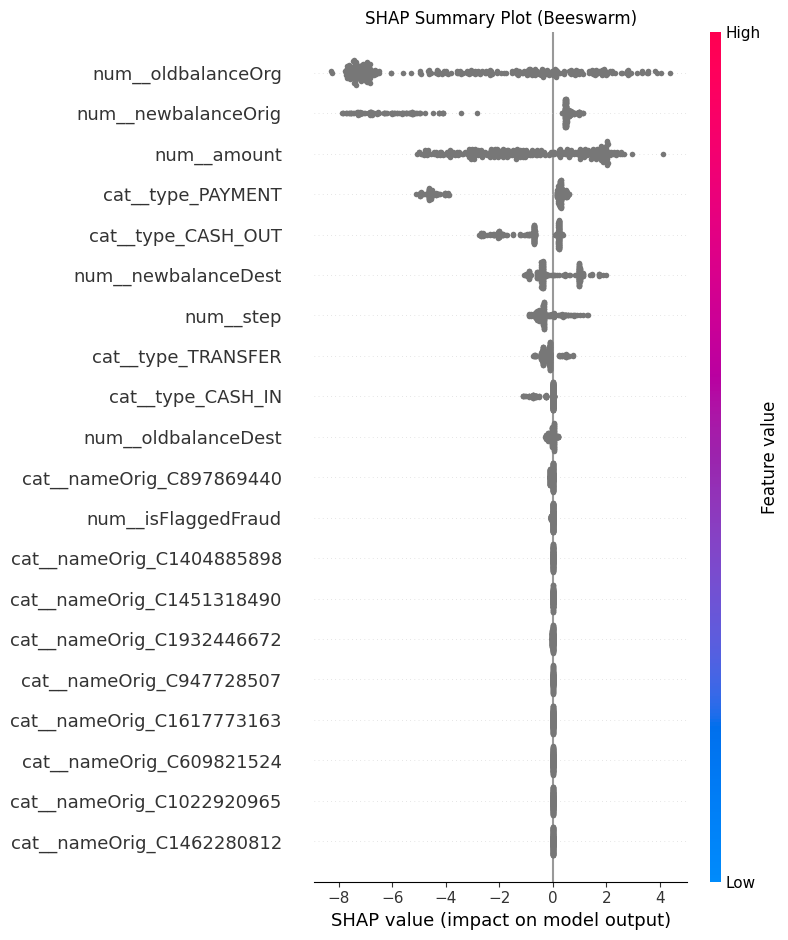

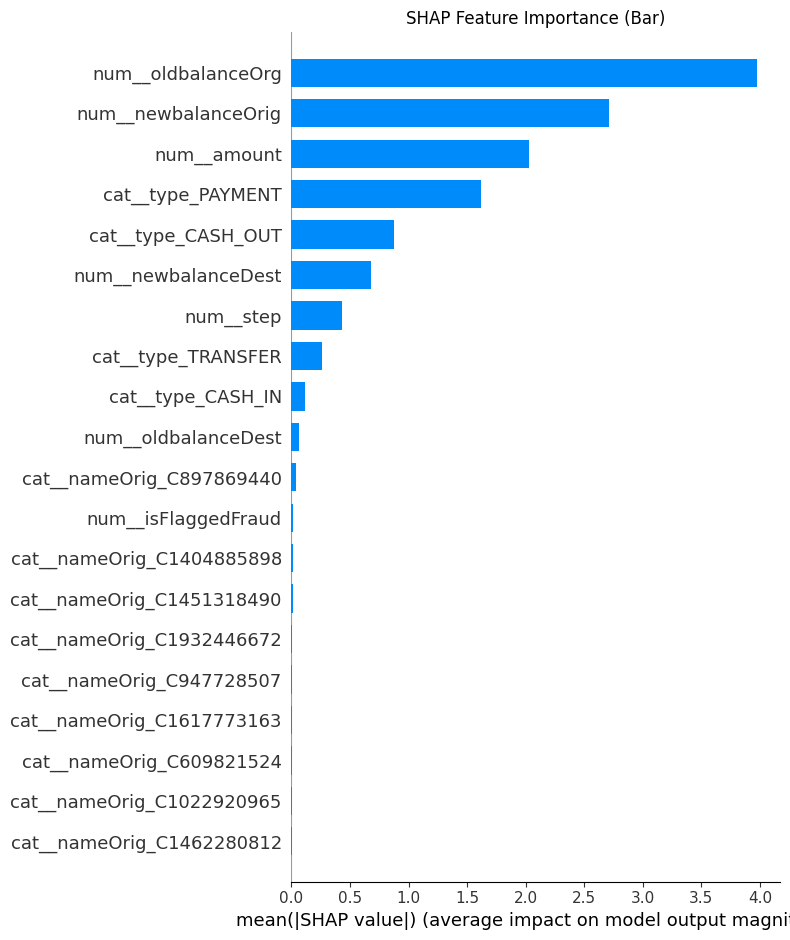

In [12]:
import shap
import matplotlib.pyplot as plt

# 2. Load the final saved model
model = joblib.load(r"C:\Users\user\Documents\GitHub\RetouchIT-ML-AI-Technical-Assessment\fraud_model.pkl")

# 3. Take a small subset of test set to avoid memory issues
X_test_sample = X_test.sample(n=300, random_state=42)

# 4. Preprocess using pipeline
X_test_transformed = model.named_steps["preprocessor"].transform(X_test_sample)
clf = model.named_steps["classifier"]

# 5. Create SHAP explainer
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test_transformed)

# 6. Get feature names from preprocessor
feature_names = model.named_steps["preprocessor"].get_feature_names_out()

# 7. SHAP Summary Beeswarm Plot
plt.title("SHAP Summary Plot (Beeswarm)")
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names)

# 8. SHAP Summary Bar Plot
plt.title("SHAP Feature Importance (Bar)")
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names, plot_type="bar")

In [ ]:
# 8. Final Test Evaluation
# =============================================== ======
print("\n================ Final Test Evaluation ================")
for name, model in final_models.items():
    y_test_pred = model.predict_proba(X_test)[:, 1]
    print(f"\n⭐ Model: {name}")
    print(f"Test PR-AUC: {average_precision_score(y_test, y_test_pred):.4f}")
    print(f"Test ROC-AUC: {roc_auc_score(y_test, y_test_pred):.4f}")
    print(classification_report(y_test, model.predict(X_test)))


================ Final Test Evaluation ================

⭐ Model: log_reg
Test PR-AUC: 0.6097
Test ROC-AUC: 0.9889
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270882
           1       0.23      0.73      0.35      1642

    accuracy                           1.00   1272524
   macro avg       0.62      0.86      0.68   1272524
weighted avg       1.00      1.00      1.00   1272524


⭐ Model: rf
Test PR-AUC: 0.0020
Test ROC-AUC: 0.6697
              precision    recall  f1-score   support

           0       1.00      0.34      0.51   1270882
           1       0.00      1.00      0.00      1642

    accuracy                           0.34   1272524
   macro avg       0.50      0.67      0.26   1272524
weighted avg       1.00      0.34      0.51   1272524


⭐ Model: xgb
Test PR-AUC: 0.9124
Test ROC-AUC: 0.9993
              precision    recall  f1-score   support

           0       1.00      0.99      0.99   1270882
           1

In [ ]:
# 9. Save Final Best Model
# =====================================================
final_model = final_models["xgb"]  # 👈 pick best based on metrics
joblib.dump(final_model, "fraud_model.pkl")
print("\n✅ Final model saved as fraud_model.pkl")


✅ Final model saved as fraud_model.pkl
